In [142]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots, redcells
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
def get_dp_thresholds(train_dp, tsh):
    if tsh > 1: # in the case we want to use a percentile
        pstv_tsh = np.percentile(train_dp, tsh) #positive threshold
        ngtv_tsh = np.percentile(train_dp, 100-tsh)
    else: # in the case we want to use a fixed value (needs to be a number lower than 1)
        pstv_tsh = tsh
        ngtv_tsh = -tsh
    return pstv_tsh, ngtv_tsh

# first day - all rewarded

In [144]:
m1 = utils.load_mouse('VG14','2024_10_15', '2', load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path='D:\mouseobj')

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_10_15\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector'])
*************************************
Mouse object loaded from local path


In [3]:
m1 = utils.load_mouse('VG14','2024_10_15', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
utils.save_mouse(m1, compressed=False, mdl_path="D:\mouseobj") #save mouse obj for later use

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_10_15\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_10_15_2.mat not found, trying with fname: VG14_2024_10_15_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:50<00:00, 20.52s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_10_15_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
Creating directory D:\mouseobj\VG14\2024_10_15\2
Mouse object saved to D:\mouseobj\VG14\2024_10_15\2


getting redcells:

In [145]:
from pathlib import Path
green_channel = Path(r"Z:\data\PROC\VG14\2024_10_15\2\suite2p")
m1.isred = redcells.get_redcells(green_channel)

(32348, 2)


In [146]:
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1.isred = m1.isred[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

37 11281
interpolating 27048 neurons, 11245 frames to
the vector of distance with shape: (11245,)
neurons: 27048, trials: 399, corridor length: 400


Red cell distribution

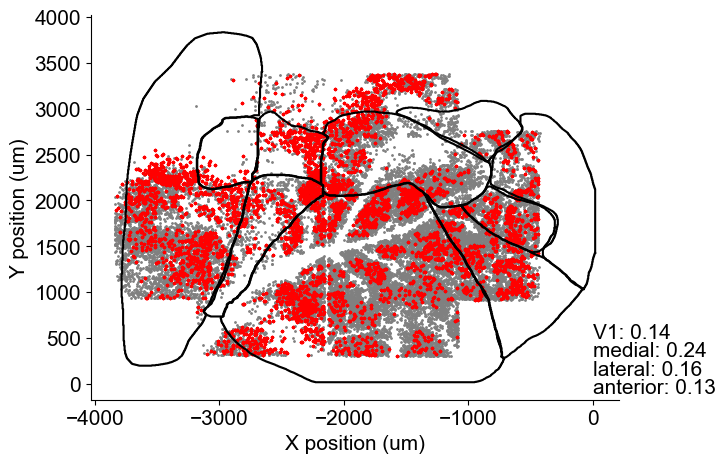

In [7]:
areas = ["V1", "medial", "lateral", "anterior"]
red = m1.isred[:,0].astype(bool)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
   
    plt.subplot(1,2,1)
    selected_neurons = a * red
    plt.text(0.2, 500-ia*200, f"{area}: {np.round(selected_neurons.sum()/a.sum(),2)}", size=15)
    #plot a reference line at 0 

    x_a = m1.xy_t[red,1]
    y_a = m1.xy_t[red,0]
    plt.scatter(x_a, y_a, c='r', s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
sns.despine()

corridor 25,275

In [147]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


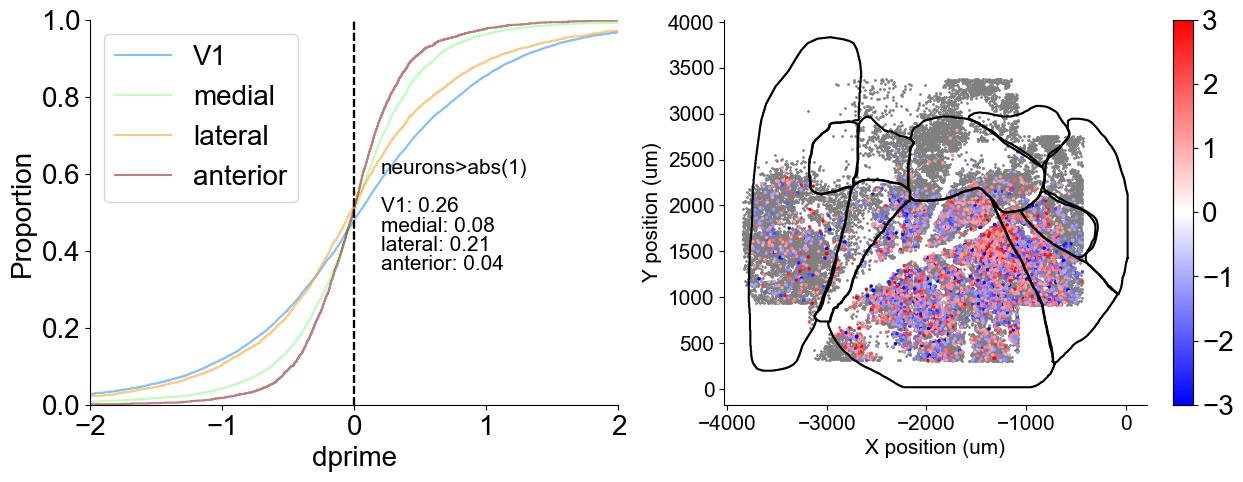

In [9]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

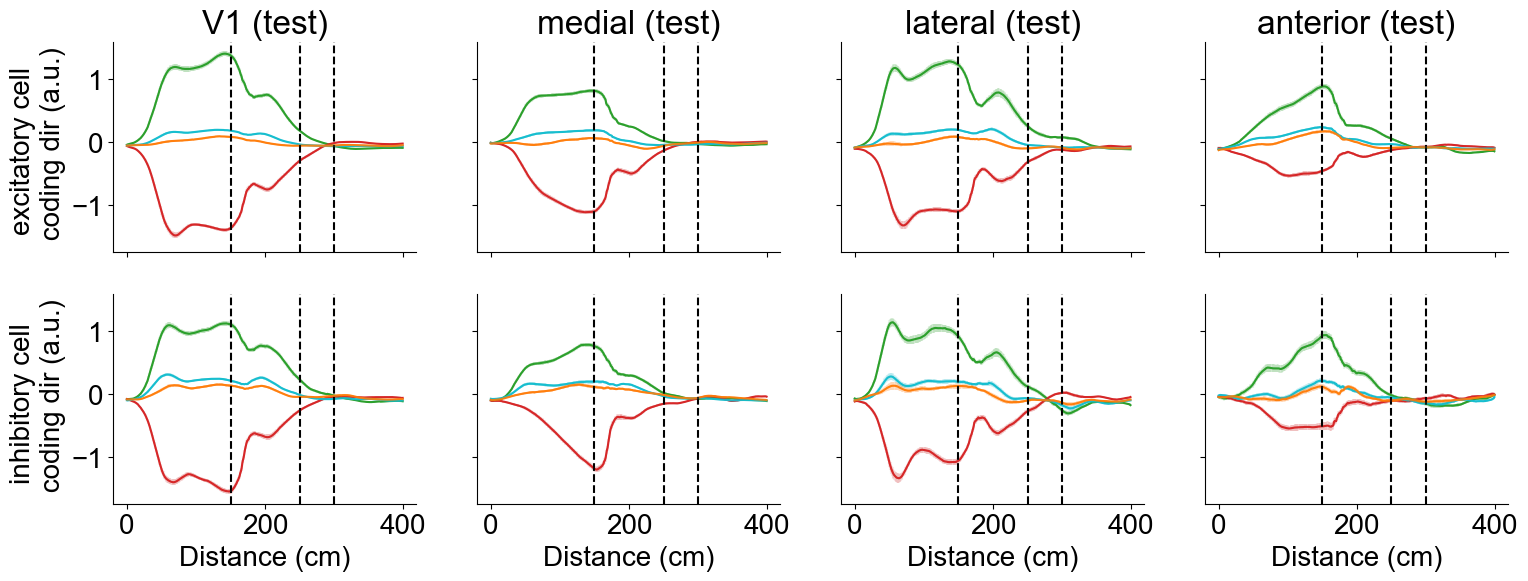

In [148]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
cod_dirs = np.empty((2, len(areas), 4, 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            cod_dirs[redcell, indexa, i_t] = avg_dir_plot.mean(0)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

In [149]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\2024_10_15\2\cod_dirs.npy", cod_dirs)

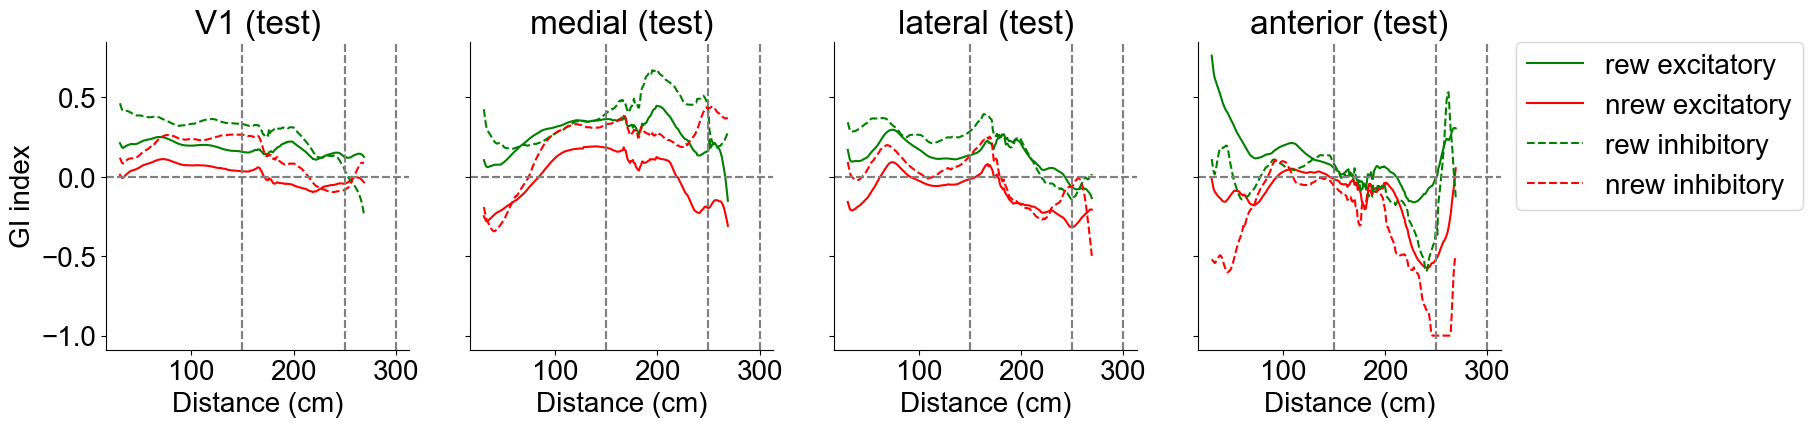

In [11]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [12]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewfirst_25_275_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewfirst_25_275_nrewGI.npy", gi_index_nrew)

first half of the corridor

In [13]:
utils.compute_dprime(m1, discrimination_region = (30,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


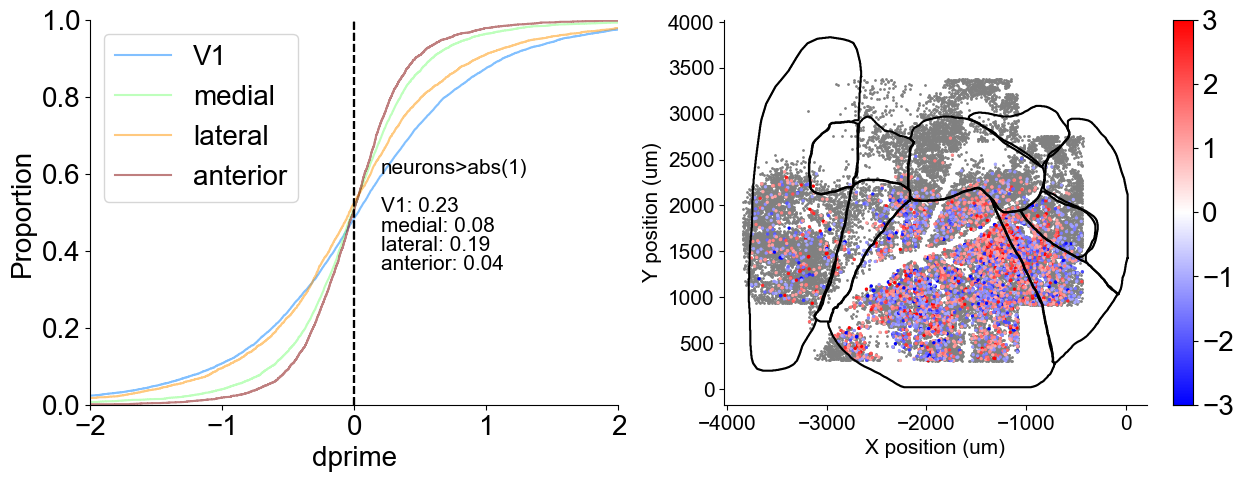

In [14]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

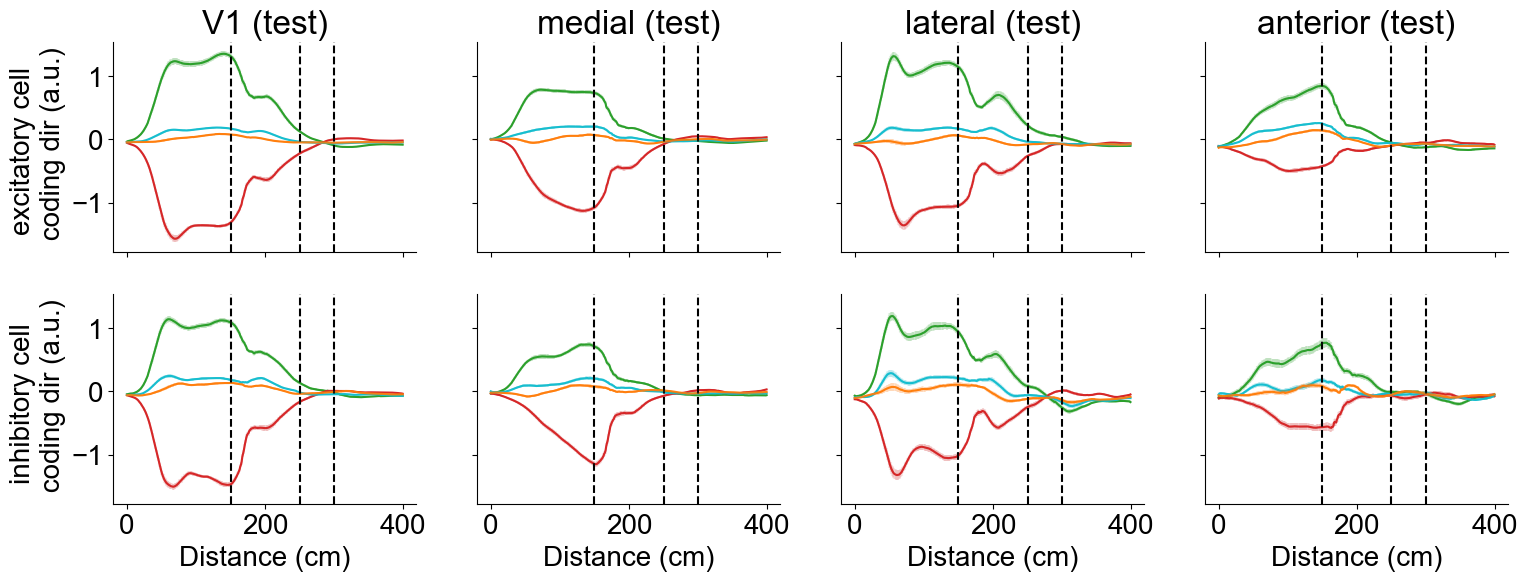

In [15]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
types = m1.isred[:,0]
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

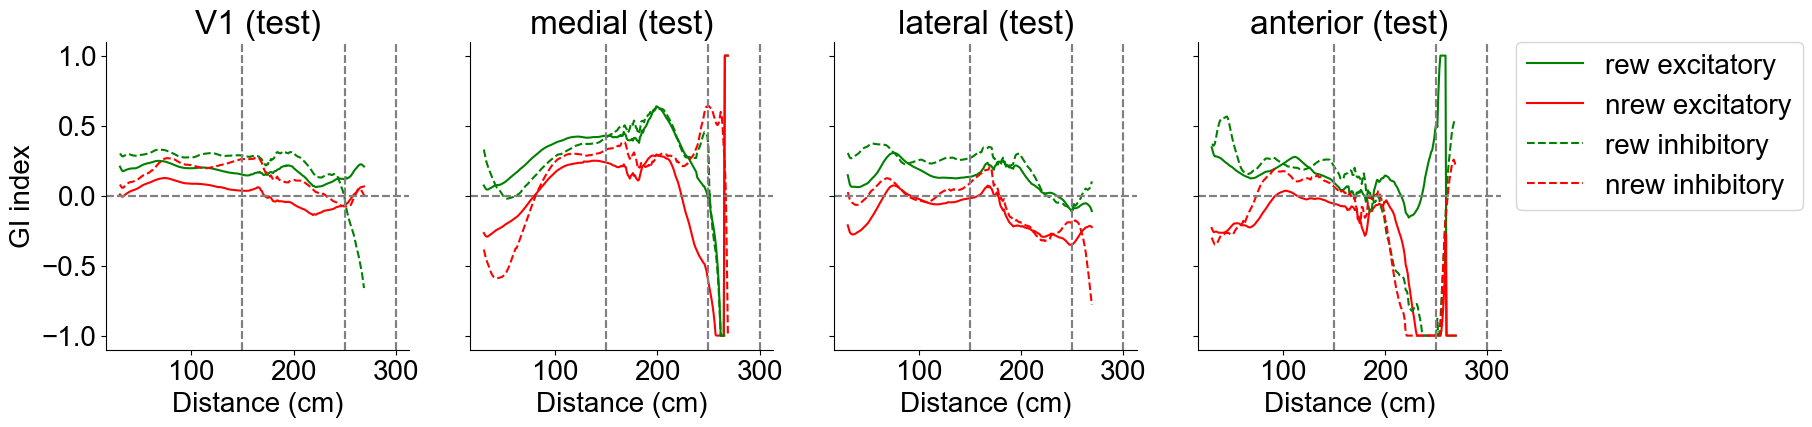

In [16]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [17]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewfirst_30_150_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewfirst_30_150_nrewGI.npy", gi_index_nrew)

First day of training

In [150]:
m1 = utils.load_mouse('VG14','2024_10_16', '2', load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path='D:\mouseobj')

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_10_16\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector'])
*************************************
Mouse object loaded from local path


In [18]:
m1 = utils.load_mouse('VG14','2024_10_16', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
utils.save_mouse(m1, compressed=False, mdl_path="D:\mouseobj") #save mouse obj for later use

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_10_16_2.mat not found, trying with fname: VG14_2024_10_16_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [07:33<00:00, 22.70s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_10_16_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
Creating directory D:\mouseobj\VG14\2024_10_16\2
Mouse object saved to D:\mouseobj\VG14\2024_10_16\2


In [151]:
from pathlib import Path
green_channel = Path(r"Z:\data\PROC\VG14\2024_10_16\2\suite2p")
m1.isred = redcells.get_redcells(green_channel)
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]
m1.isred = m1.isred[m1._snr>=.25]
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

(35951, 2)
40 13457
interpolating 31829 neurons, 13418 frames to
the vector of distance with shape: (13418,)
neurons: 31829, trials: 399, corridor length: 400


In [152]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


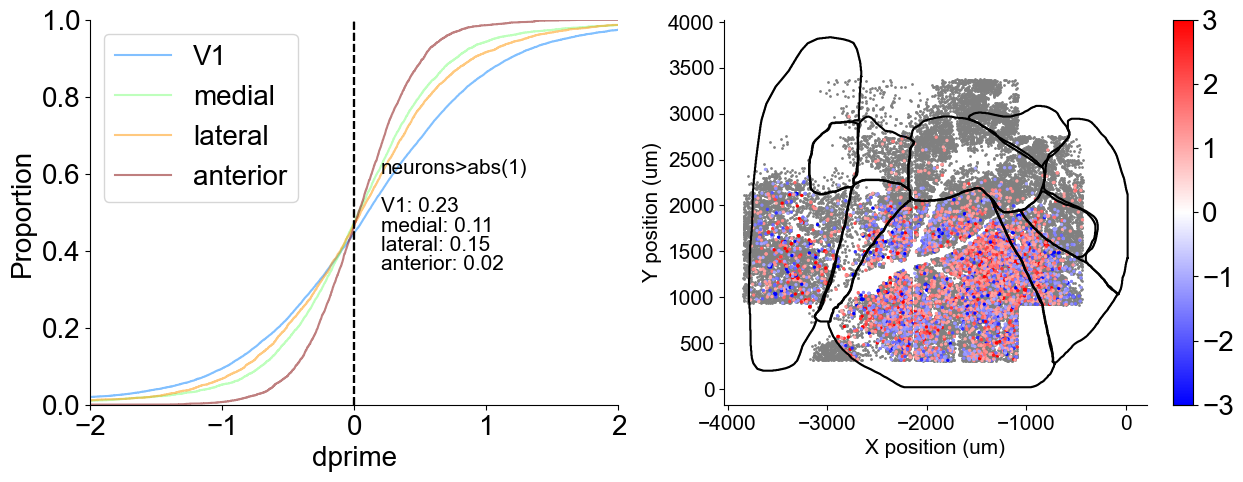

In [21]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

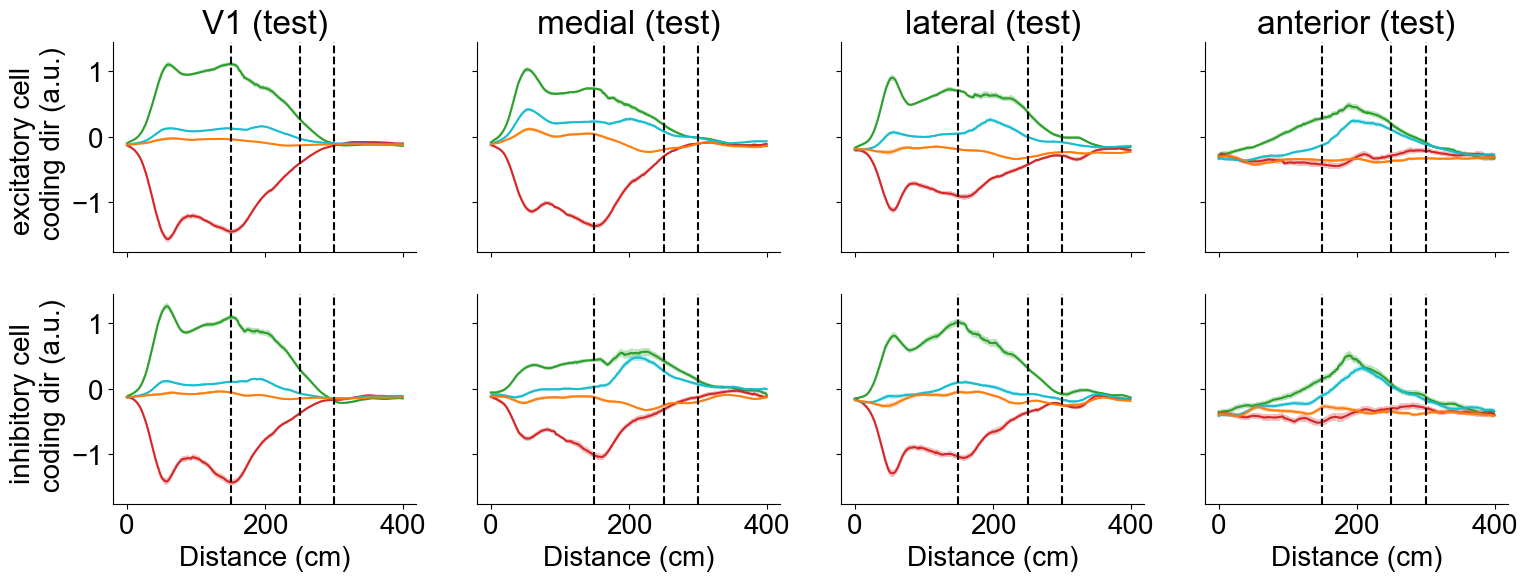

In [153]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
cod_dirs = np.empty((2, len(areas), 4, 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            cod_dirs[redcell, indexa, i_t] = avg_dir_plot.mean(0)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

In [154]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\2024_10_16\2\cod_dirs.npy", cod_dirs)

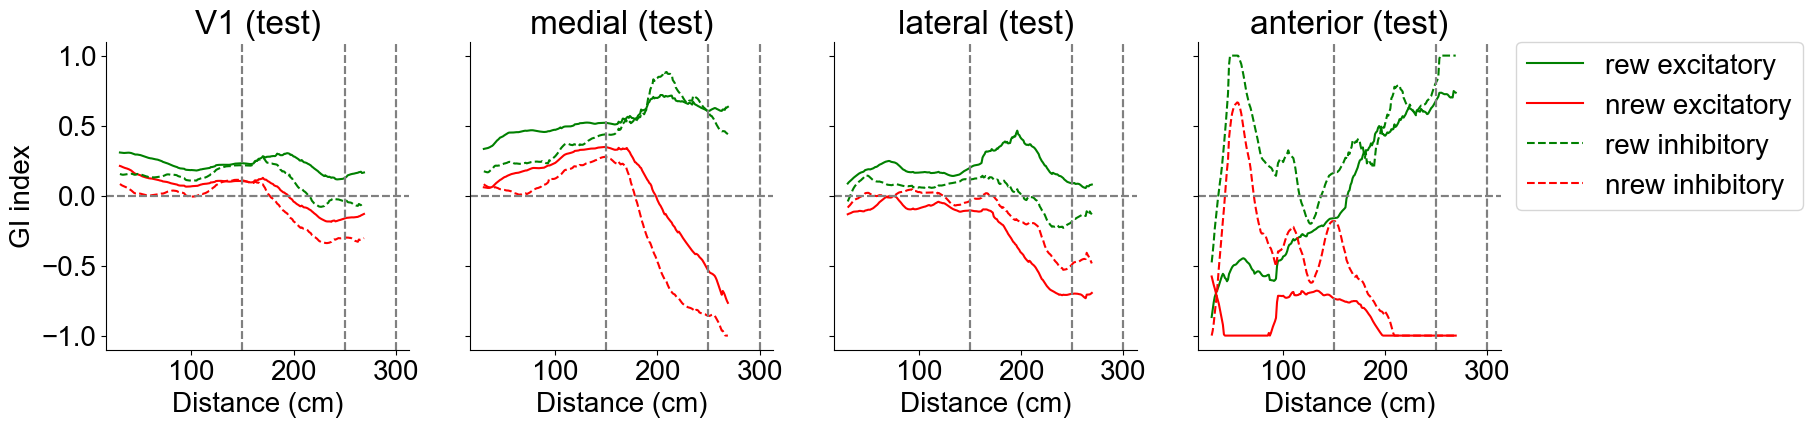

In [23]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [24]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\firsttrain_25_275_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\firsttrain_25_275_nrewGI.npy", gi_index_nrew)

In [25]:
utils.compute_dprime(m1, discrimination_region = (30,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


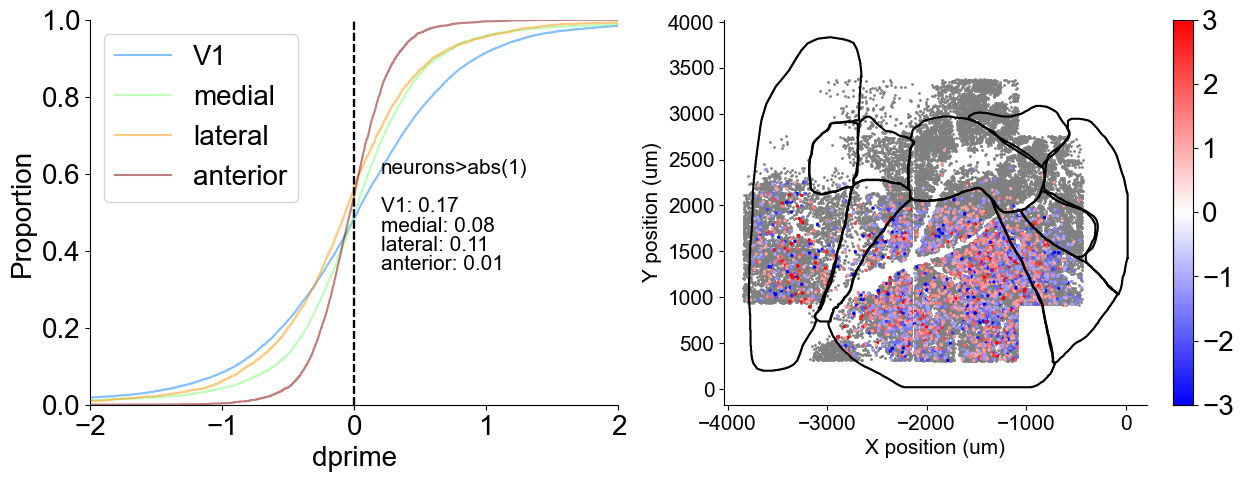

In [26]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

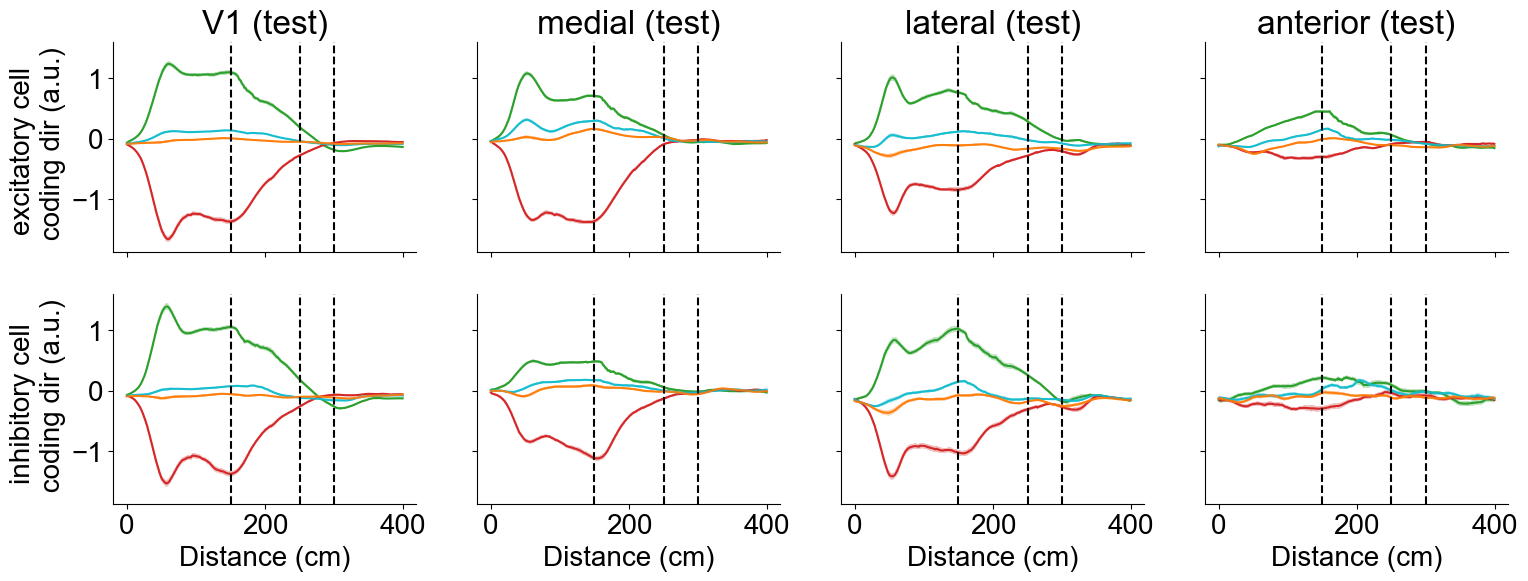

In [27]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
types = m1.isred[:,0]
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

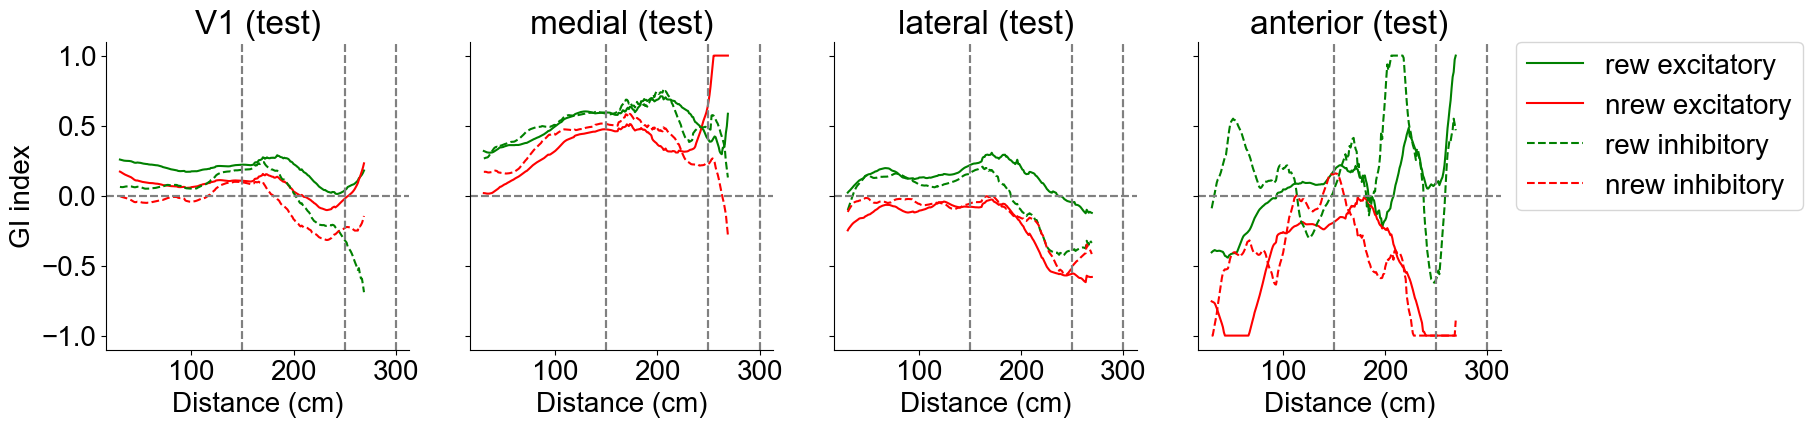

In [28]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [29]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\firsttrain_30_150_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\firsttrain_30_150_nrewGI.npy", gi_index_nrew)

# Optimal day of behavior

In [155]:
m1 = utils.load_mouse('VG14','2024_11_21', '2', load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path='D:\mouseobj')

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector'])
*************************************
Mouse object loaded from local path


In [30]:
m1 = utils.load_mouse('VG14','2024_11_21', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
utils.save_mouse(m1, compressed=False, mdl_path="D:\mouseobj") #save mouse obj for later use

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_11_21\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_11_21_2.mat not found, trying with fname: VG14_2024_11_21_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [07:05<00:00, 21.29s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_11_21_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
Creating directory D:\mouseobj\VG14\2024_11_21\2
Mouse object saved to D:\mouseobj\VG14\2024_11_21\2


In [156]:
from pathlib import Path
green_channel = Path(r"Z:\data\PROC\VG14\2024_11_21\2\suite2p")
m1.isred = redcells.get_redcells(green_channel)
m1.isred = m1.isred[m1._snr>=.25]
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]

(34859, 2)


In [157]:
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

41 11762
interpolating 29439 neurons, 11722 frames to
the vector of distance with shape: (11722,)
neurons: 29439, trials: 371, corridor length: 400


In [158]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


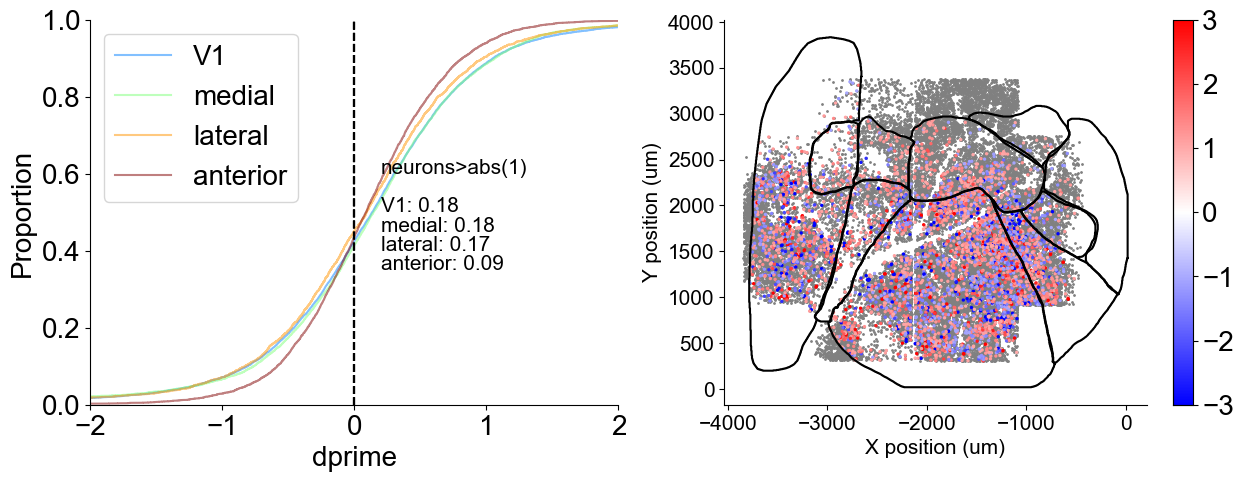

In [34]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

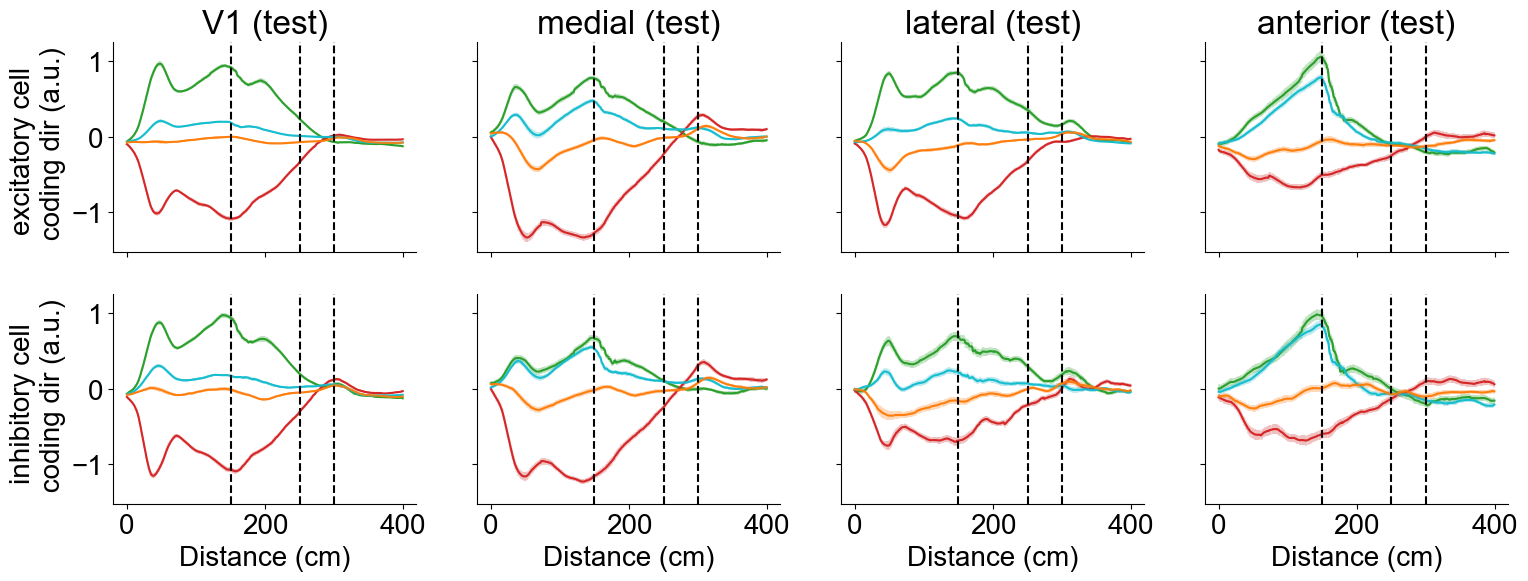

In [159]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
cod_dirs = np.empty((2, len(areas), 4, 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            cod_dirs[redcell, indexa, i_t] = avg_dir_plot.mean(0)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

In [160]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\2024_11_21\2\cod_dirs.npy", cod_dirs)

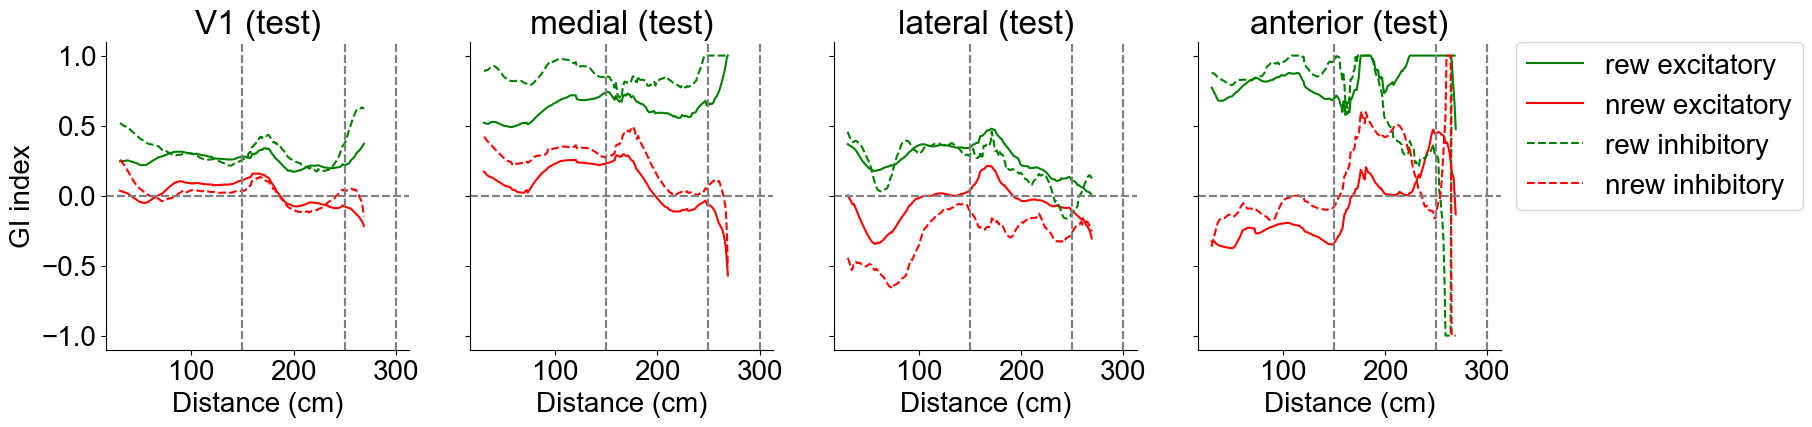

In [36]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [37]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\optimal_25_275_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\optimal_25_275_nrewGI.npy", gi_index_nrew)

# Lick contribution

In [38]:
trials_licks = {}
trials_nolicks = {}
for k in m1.trial_dict.keys():
    t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=k)
    trials_licks[k] = t_licks
    trials_nolicks[k] = t_no_licks

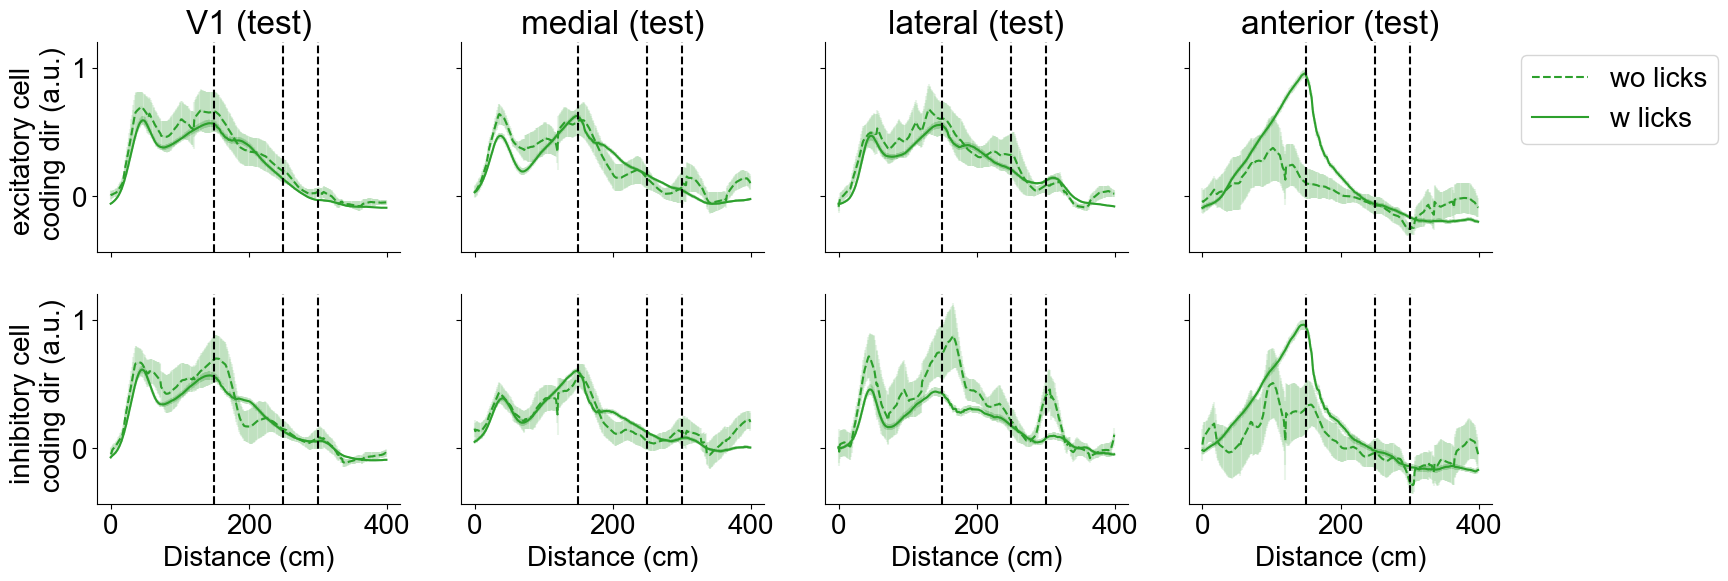

In [39]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])


fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        avg_dir_plot = avg_dir[rtrials_nolick]
        ax[redcell, indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
        ax[redcell, indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
        avg_dir_plot = avg_dir[rtrials_wlick]
        ax[redcell, indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

Text(0, 0.5, 'Rewarded trials wo licks')

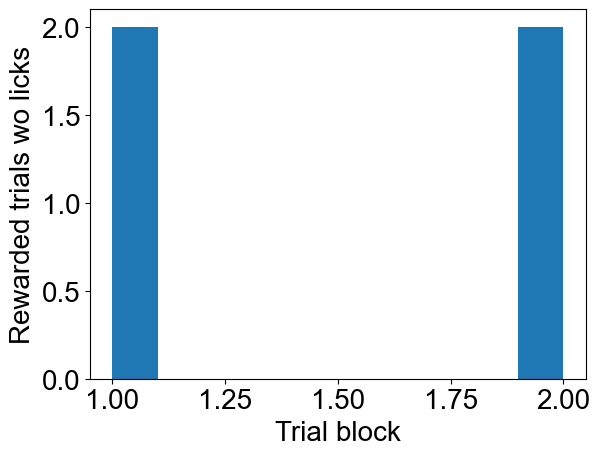

In [60]:
sorted_r_wlick = np.sort((rtrials_nolick))
plt.hist(pd.cut(sorted_r_wlick, bins=[0,75,150,225,300], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Rewarded trials wo licks')

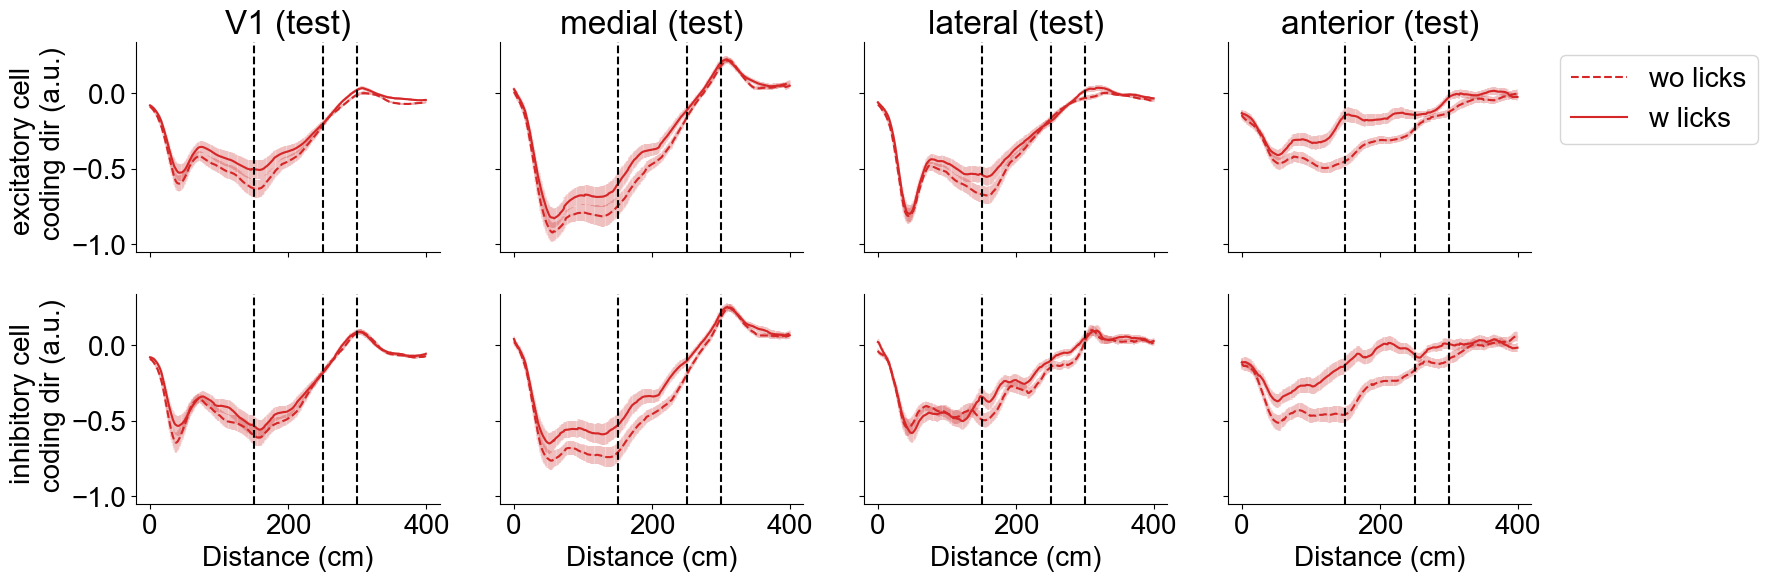

In [40]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])


fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        avg_dir_plot = avg_dir[nrtrials_nolick]
        ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
        avg_dir_plot = avg_dir[nrtrials_wlick]
        ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

Text(0, 0.5, 'Rewarded trials wo licks')

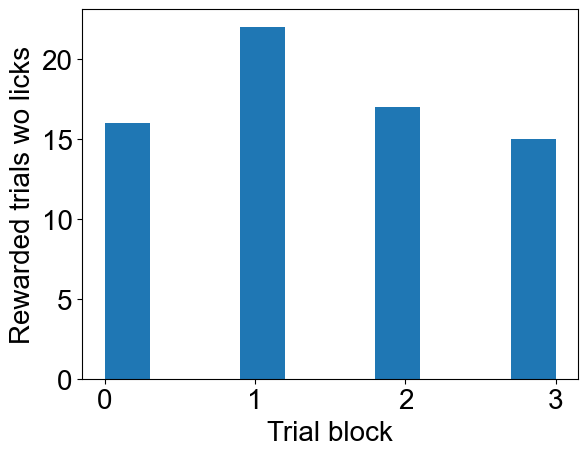

In [61]:
sorted_nr_wlick = np.sort((nrtrials_wlick))
plt.hist(pd.cut(sorted_nr_wlick, bins=[0,75,150,225,300], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Rewarded trials wo licks')

# half of the corridor

In [41]:
utils.compute_dprime(m1, discrimination_region = (30,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


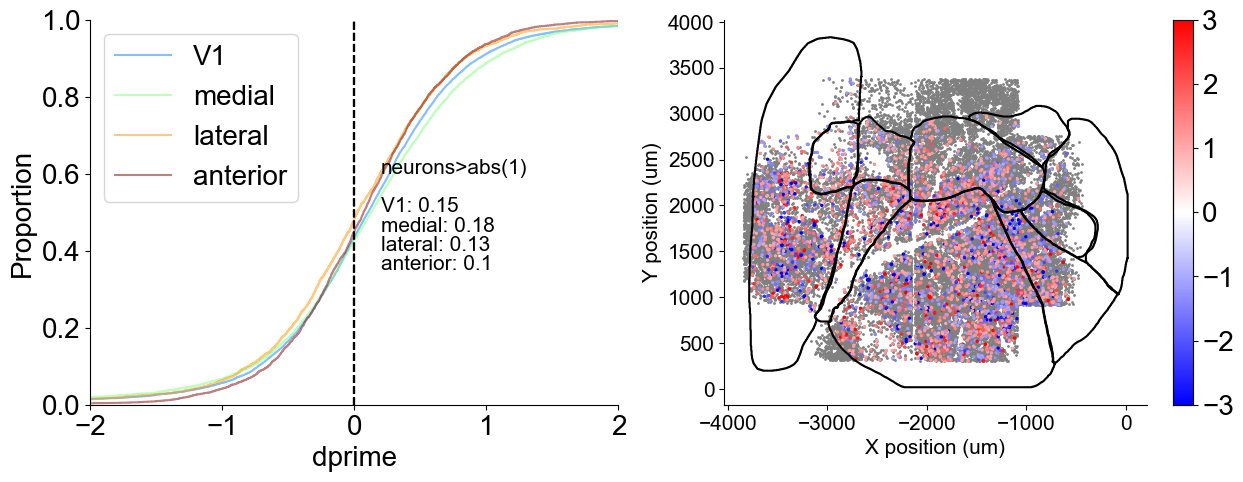

In [42]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

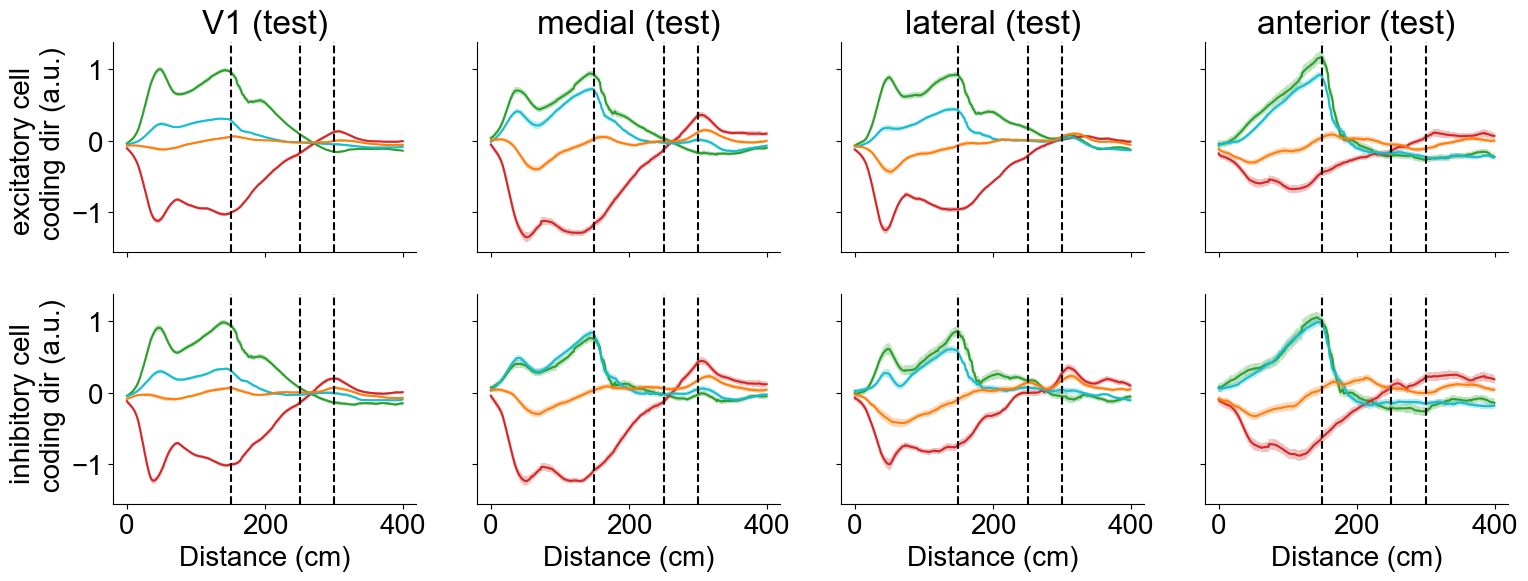

In [43]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

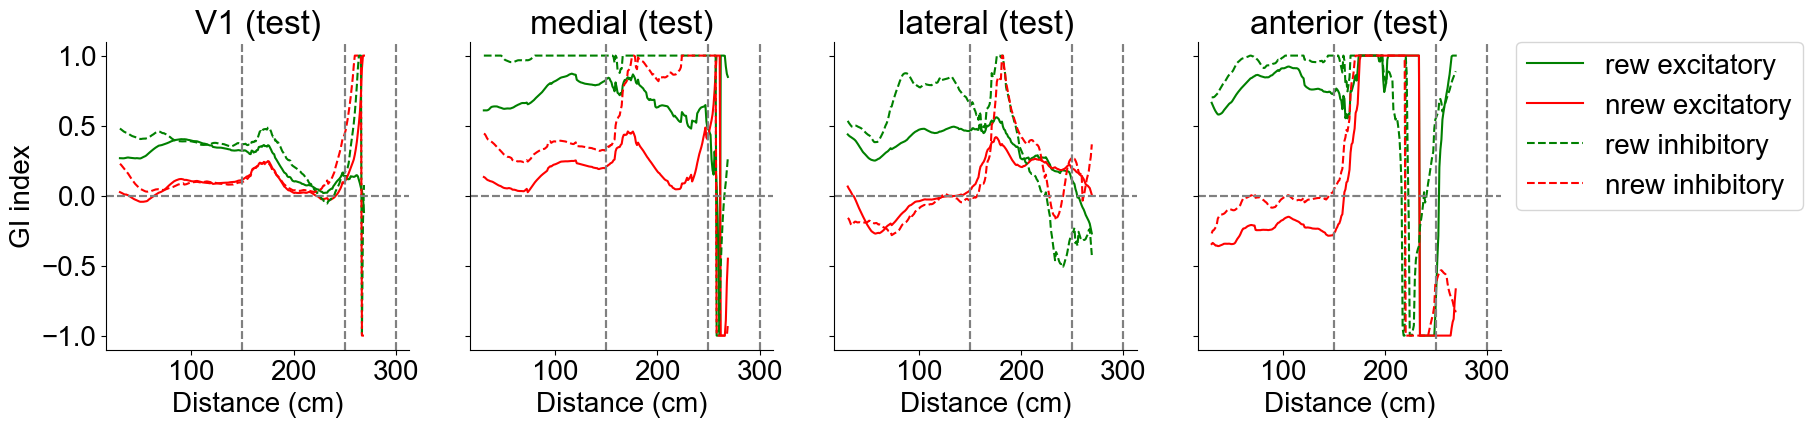

In [44]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [45]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\optimal_30_150_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\optimal_30_150_nrewGI.npy", gi_index_nrew)

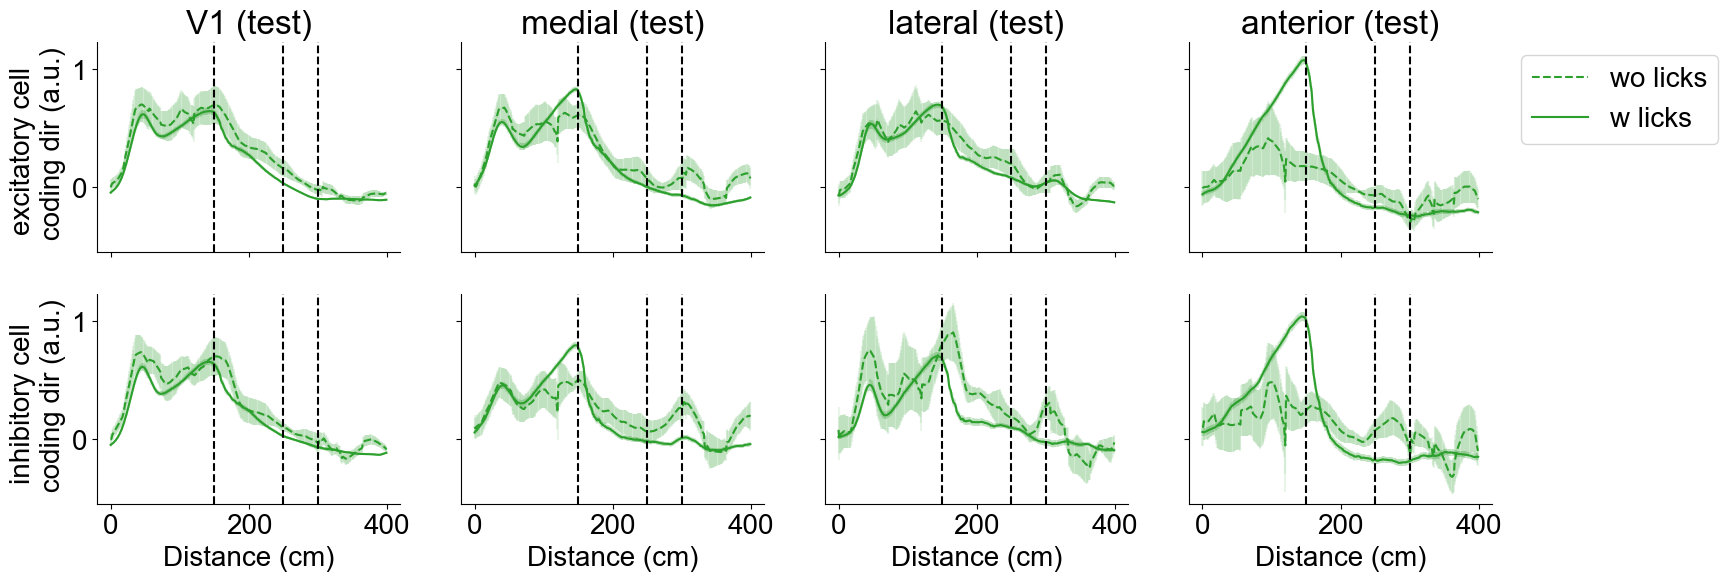

In [46]:
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        avg_dir_plot = avg_dir[rtrials_nolick]
        ax[redcell, indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
        ax[redcell, indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
        avg_dir_plot = avg_dir[rtrials_wlick]
        ax[redcell, indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

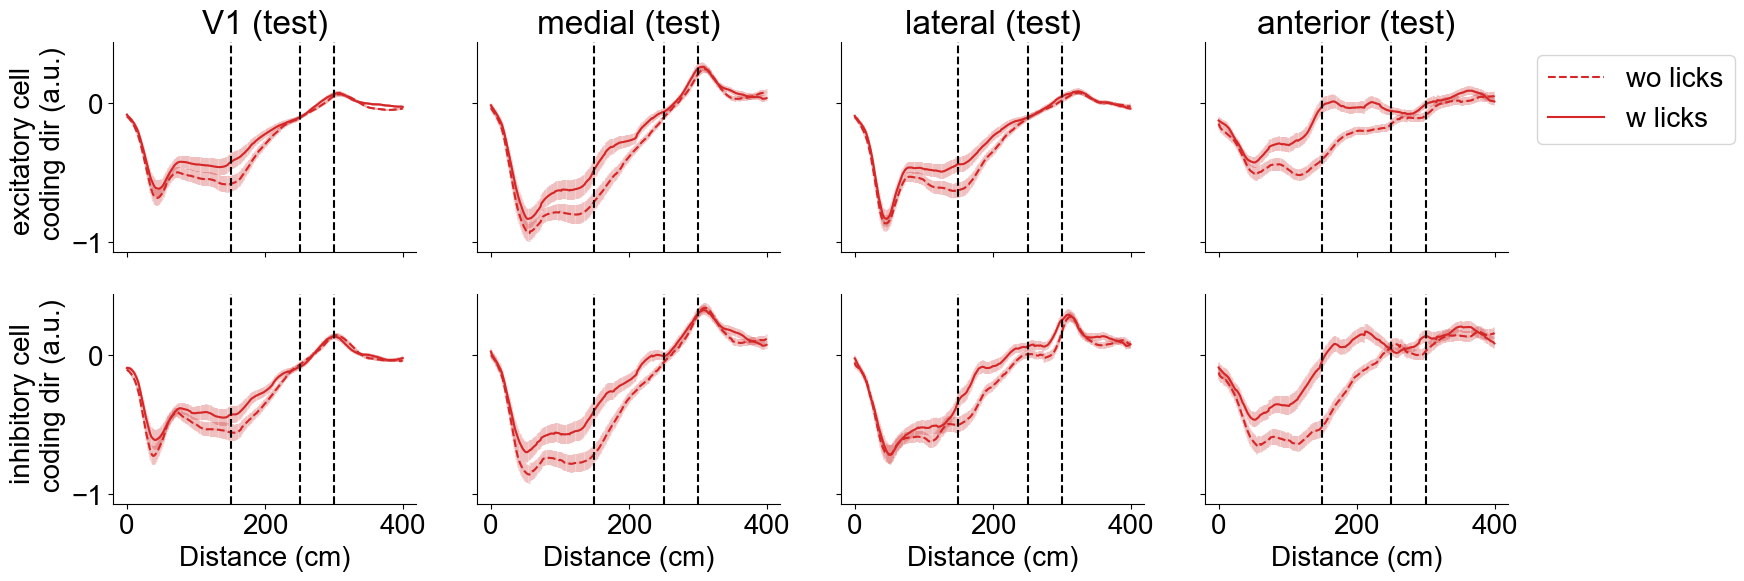

In [47]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])


fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        avg_dir_plot = avg_dir[nrtrials_nolick]
        ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
        avg_dir_plot = avg_dir[nrtrials_wlick]
        ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
        ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

# last rew

In [161]:
m1 = utils.load_mouse('VG14','2024_11_23', '2', load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path="D:\mouseobj")

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_23\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector'])
*************************************
Mouse object loaded from local path


In [48]:
m1 = utils.load_mouse('VG14','2024_11_23', '2', load_neurons=True, interp_behav=True, load_retinotopy=True)
frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = (frameselector.reset_index()
      .rename(columns = {'index':'frame'})
      .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
      .set_index('frame'))
utils.save_mouse(m1, compressed=False, mdl_path="D:\mouseobj") #save mouse obj for later use

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG14\2024_11_23\2
Creating new mouse object ...
Timeline with fname: Timeline_VG14_2024_11_23_2.mat not found, trying with fname: VG14_2024_11_23_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [06:22<00:00, 19.12s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\behav\VG14_2024_11_23_2_behav.npz
*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline'])
Creating directory D:\mouseobj\VG14\2024_11_23\2
Mouse object saved to D:\mouseobj\VG14\2024_11_23\2


In [162]:
from pathlib import Path
green_channel = Path(r"Z:\data\PROC\VG14\2024_11_23\2\suite2p")
m1.isred = redcells.get_redcells(green_channel)
m1.isred = m1.isred[m1._snr>=.25]
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1.iarea = m1.iarea[m1._snr>=.25]
m1.iregion = m1.iregion[m1._snr>=.25]
m1.xy_t = m1.xy_t[m1._snr>=.25]

(30553, 2)


In [163]:
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

38 12461
interpolating 26262 neurons, 12423 frames to
the vector of distance with shape: (12423,)
neurons: 26262, trials: 187, corridor length: 400


In [169]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


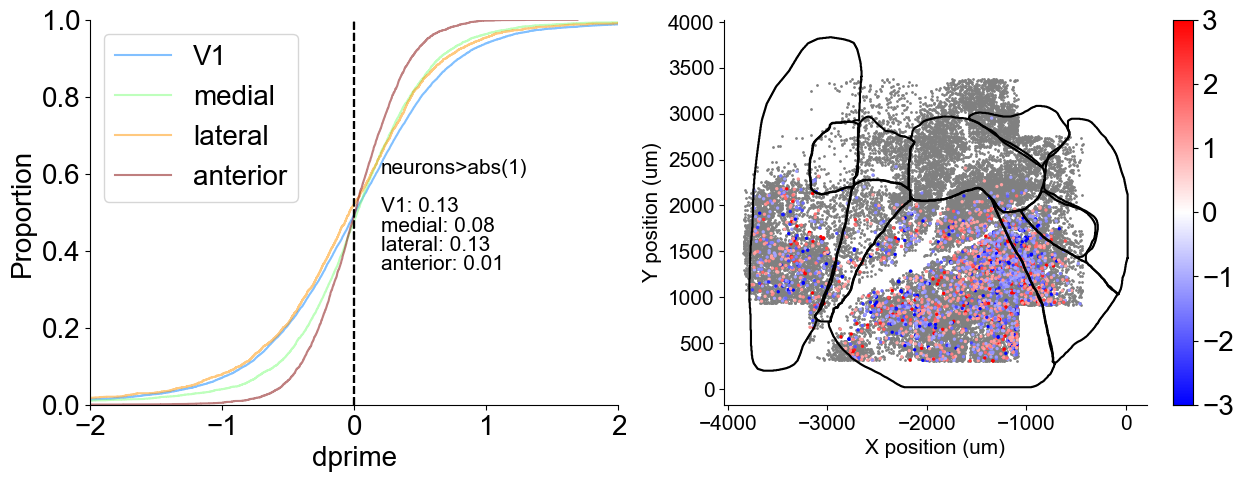

In [52]:
area_dict = {
    "V1": '#0683FF',
    "medial": '#7EFF7B',
    "lateral": '#FF9400',
    "anterior": '#800000'
}
areas = ["V1", "medial", "lateral", "anterior"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.scatter(m1.xy_t[:,1], m1.xy_t[:, 0], c = 'gray', s = 1)
tsh = 1
for j in range(len(m1.outline)):
    plt.plot(m1.outline[j][:,1], m1.outline[j][:,0], '-k')
plt.subplot(1,2,1)
plt.text(0.2, 0.6, f"neurons>abs({tsh})", size=15)
for ia, area in enumerate(areas):
    a = utils.get_region_idx(m1.iarea,area)
    plt.subplot(1,2,1)
    selected_neurons = np.abs(m1.train_dp[a]) > tsh
    sns.ecdfplot(m1.train_dp[a], alpha = .5, color = area_dict[area], label = area)
    plt.xlabel("dprime")
    
    plt.text(0.2, 0.5-ia*.05, f"{area}: {np.round(selected_neurons.sum()/selected_neurons.shape[0],2)}", size=15)
    #plot a reference line at 0 
    plt.axvline(0, color = 'k', linestyle = '--')
    plt.xlim(-2,2)
    plt.legend()
    plt.subplot(1,2,2)
    
    dp_a = m1.train_dp[a]
    x_a = m1.xy_t[a,1]
    y_a = m1.xy_t[a,0]
    plt.scatter(x_a[selected_neurons], y_a[selected_neurons], c=dp_a[selected_neurons], cmap = 'bwr', vmax = 3, vmin=-3, s = 2)

plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

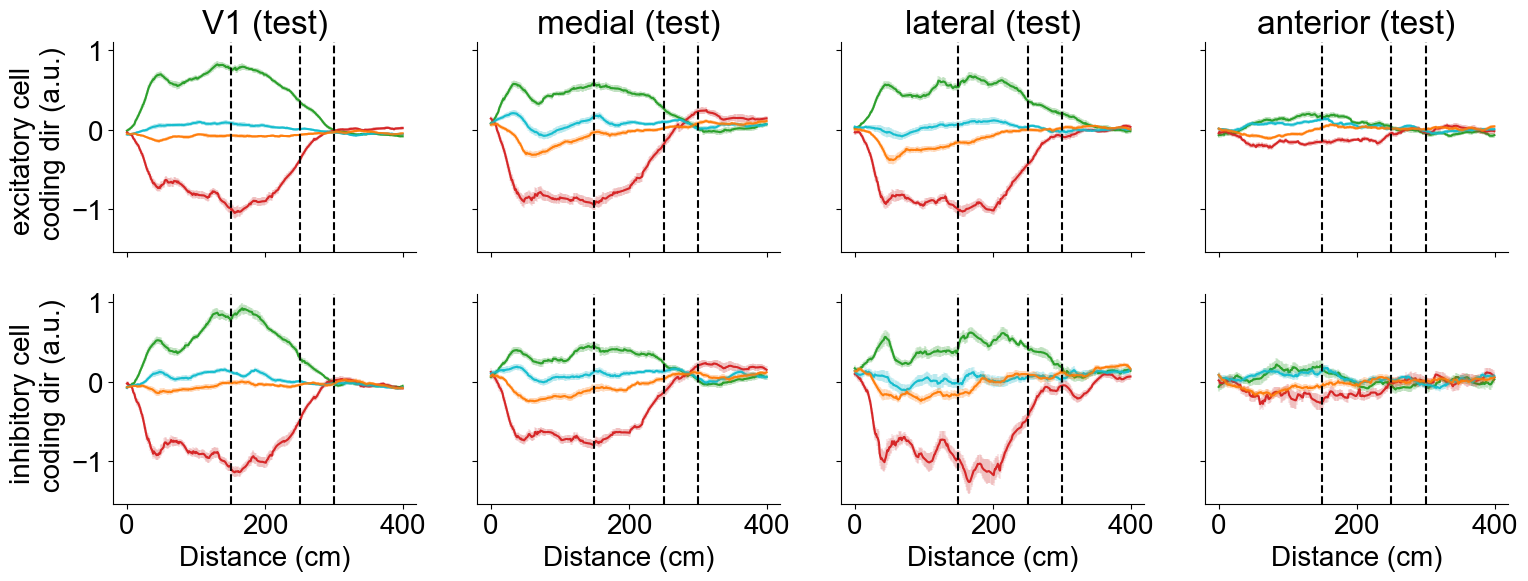

In [170]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
cod_dirs = np.empty((2, len(areas), 4, 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            cod_dirs[redcell, indexa, i_t] = avg_dir_plot.mean(0)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

In [171]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\2024_11_23\2\cod_dirs.npy", cod_dirs)

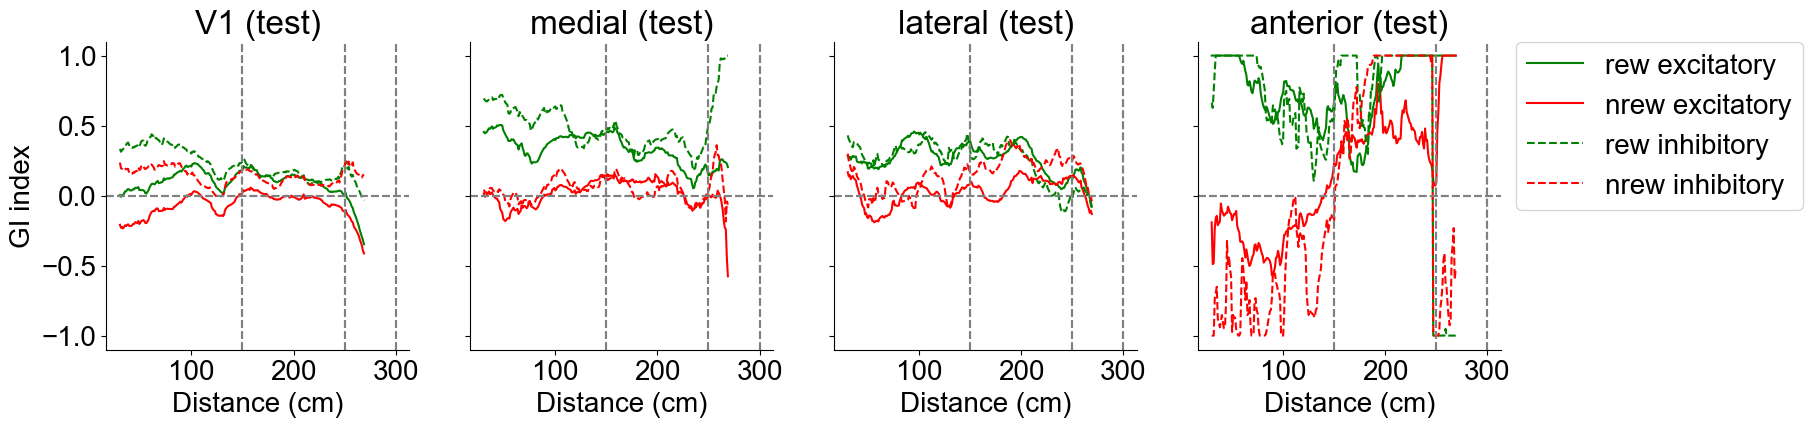

In [54]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [55]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewlast_25_275_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewlast_25_275_nrewGI.npy", gi_index_nrew)

In [56]:
utils.compute_dprime(m1, discrimination_region = (30,150), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials


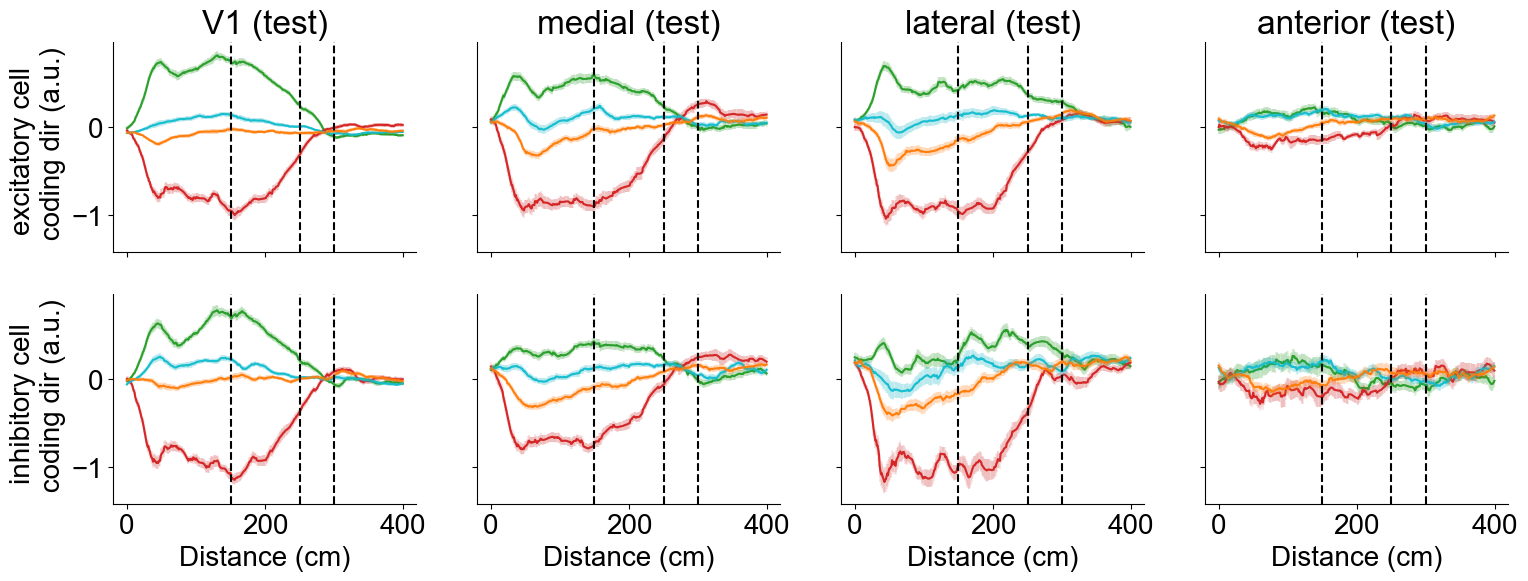

In [ ]:
from scipy.stats import sem
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
cod_dirs = np.empty((2, len(areas), 4, 400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
            if ttype in ['rewarded', 'non rewarded']:    
                trials = trials[1::2] # odd trials only
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            else:
                avg_dir_plot = avg_dir[trials]
                ax[redcell,indexa].errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
                ax[redcell,indexa].plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
            cod_dirs[redcell, indexa, i_t] = avg_dir_plot.mean(0)
        ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
        ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
        if redcell == 0:
            ax[redcell,indexa].set_xlabel('')
            ax[redcell,indexa].set_title(f"{area} (test)")
        else:
            ax[redcell,indexa].set_xlabel('Distance (cm)')
    # if indexa != 0 do not plot the yticks
        if indexa == 0:
            if redcell == 0:
                ax[redcell,indexa].set_ylabel('excitatory cell \n coding dir (a.u.)')
            else:
                ax[redcell,indexa].set_ylabel('inhibitory cell \n coding dir (a.u.)')
sns.despine()

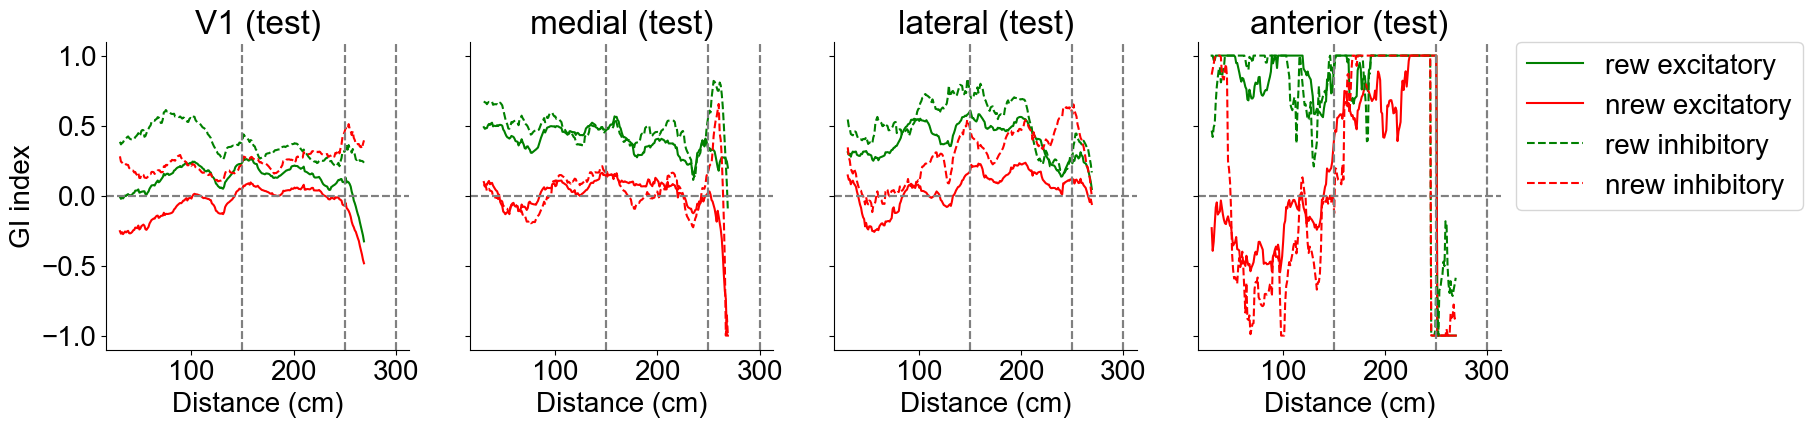

In [58]:
fig, ax = plt.subplots(1,4, figsize=(18,4), sharey=True)
avg_resp = np.empty((4, 400))
gi_index_rew = np.empty((2,4,400))
gi_index_nrew = np.empty((2,4,400))
for indexa, area in enumerate(areas):
    ia = utils.get_region_idx(m1.iarea, area)
    for redcell in range(2):
        if redcell == 0: 
            selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
        else:
            selected_type = m1.isred[:,0].astype(bool)
        pstv_tsh, ngtv_tsh = get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) #tresh based on the area 
        prefer_r = (m1.train_dp>=pstv_tsh)
        prefer_nr = (m1.train_dp<=ngtv_tsh)
        area_prefer_r = prefer_r * ia * selected_type
        area_prefer_nr = prefer_nr * ia * selected_type
        dir_for_type = m1.interp_spks 
        dir_for_type = dir_for_type[area_prefer_r] - dir_for_type[area_prefer_nr]
        avg_dir = dir_for_type.mean(0)
        for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):    
                trials = trials[1::2] # even trials only
                avg_dir_plot = avg_dir[trials]
                avg_resp[i_t] = avg_dir_plot.mean(0)
        red_cyan = np.abs(avg_resp[1] - avg_resp[2])
        green_cyan = np.abs(avg_resp[0] - avg_resp[2])
        red_orange = np.abs(avg_resp[1] - avg_resp[3])
        green_orange = np.abs(avg_resp[0] - avg_resp[3])
        green_red  = np.abs(avg_resp[0] - avg_resp[1])
        gi_index_rew[redcell,indexa] = (red_cyan - green_cyan) / green_red
        gi_index_nrew[redcell,indexa] = (red_orange - green_orange) / green_red
        g_plot_r = gi_index_rew[redcell,indexa]
        g_plot_nr = gi_index_nrew[redcell,indexa]
        if redcell == 0: 
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linewidth = 1.5, label = 'rew excitatory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linewidth = 1.5, label = 'nrew excitatory')
        else:
            ax[indexa].plot(np.arange(30,270), g_plot_r[30:270], color = 'g', linestyle='--', linewidth = 1.5, label = 'rew inhibitory')
            ax[indexa].plot(np.arange(30,270), g_plot_nr[30:270], color = 'r', linestyle='--', linewidth = 1.5, label = 'nrew inhibitory')
        ax[indexa].set_title(f"{area} (test)")
        ax[indexa].axvline(x=150, color='gray', linestyle='--')
        ax[indexa].axvline(x=250, color='gray', linestyle='--')
        ax[indexa].axvline(x=300, color='gray', linestyle='--')
        ax[indexa].axhline(y=0, color='gray', linestyle='--')
        ax[indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
        if indexa == 0:
            ax[indexa].set_ylabel('GI index')
        if indexa == 3:
            ax[indexa].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

In [59]:
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewlast_30_150_rewGI.npy", gi_index_rew)
np.save(r"C:\Users\labadmin\Documents\category-neural\data\VG14\allrewlast_30_150_nrewGI.npy", gi_index_nrew)

In [62]:
all_rew_first = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\allrewfirst_25_275_rewGI.npy")
first_train = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\firsttrain_25_275_rewGI.npy")
optimal = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\optimal_25_275_rewGI.npy")
all_rew_last = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\allrewlast_25_275_rewGI.npy")

In [63]:
gis = np.vstack([all_rew_first, first_train, optimal, all_rew_last]).reshape(4,2,4,400)

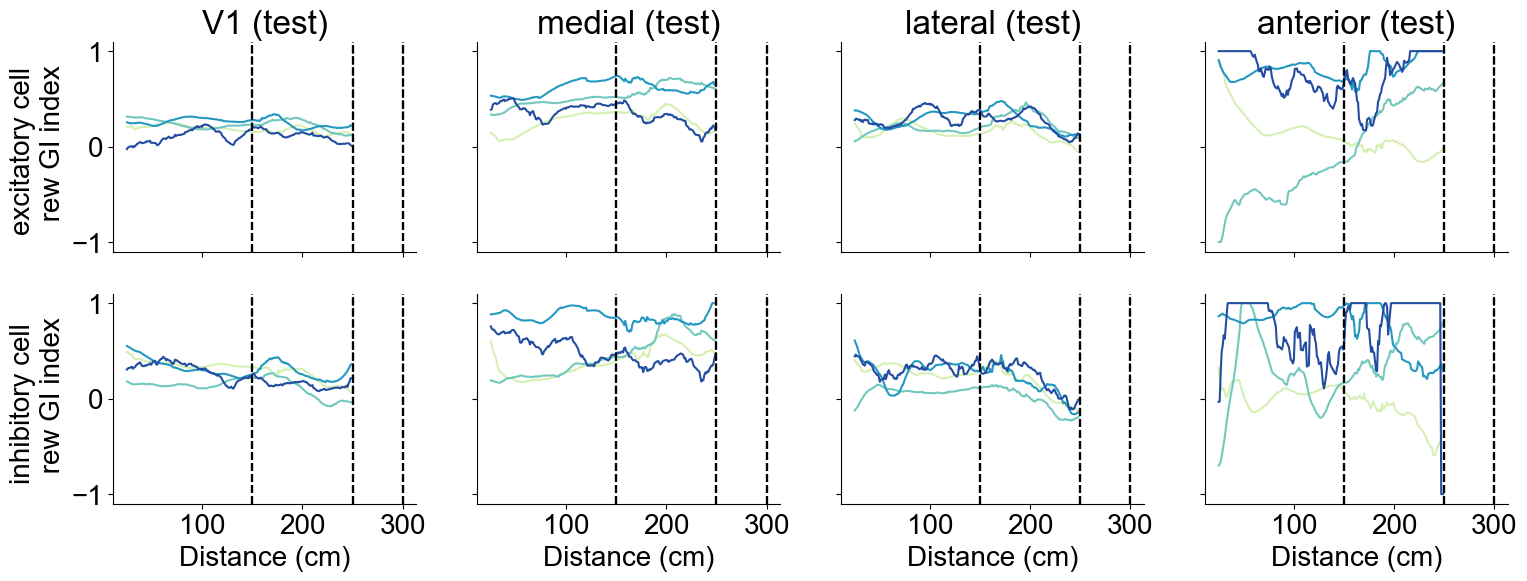

In [64]:
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
palette = sns.color_palette('YlGnBu', 4)  # 4 colors for 4 days
for day in range(4):
    for indexa, area in enumerate(areas):
        for redcell in range(2):
            gi_a = gis[day,redcell,indexa,:]
            gi_a = gi_a[25:250]
            ax[redcell,indexa].plot(np.arange(25,250), gi_a, color = palette[day], linewidth = 1.5)
            ax[redcell,indexa].set_xlabel('Distance (cm)')
            ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
            ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
            ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
            if redcell == 0:
                ax[redcell,indexa].set_xlabel('')
                ax[redcell,indexa].set_title(f"{area} (test)")
            else:
                ax[redcell,indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
            if indexa == 0:
                if redcell == 0:
                    ax[redcell,indexa].set_ylabel('excitatory cell \n rew GI index')
                else:
                    ax[redcell,indexa].set_ylabel('inhibitory cell \n rew GI index')
sns.despine()

In [65]:
all_rew_first_n = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\allrewfirst_25_275_nrewGI.npy")
first_train_n = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\firsttrain_25_275_nrewGI.npy")
optimal_n = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\optimal_25_275_nrewGI.npy")
all_rew_last_n = np.load(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\allrewlast_25_275_nrewGI.npy")

In [66]:
gis_n = np.vstack([all_rew_first_n, first_train_n, optimal_n, all_rew_last_n]).reshape(4,2,4,400)

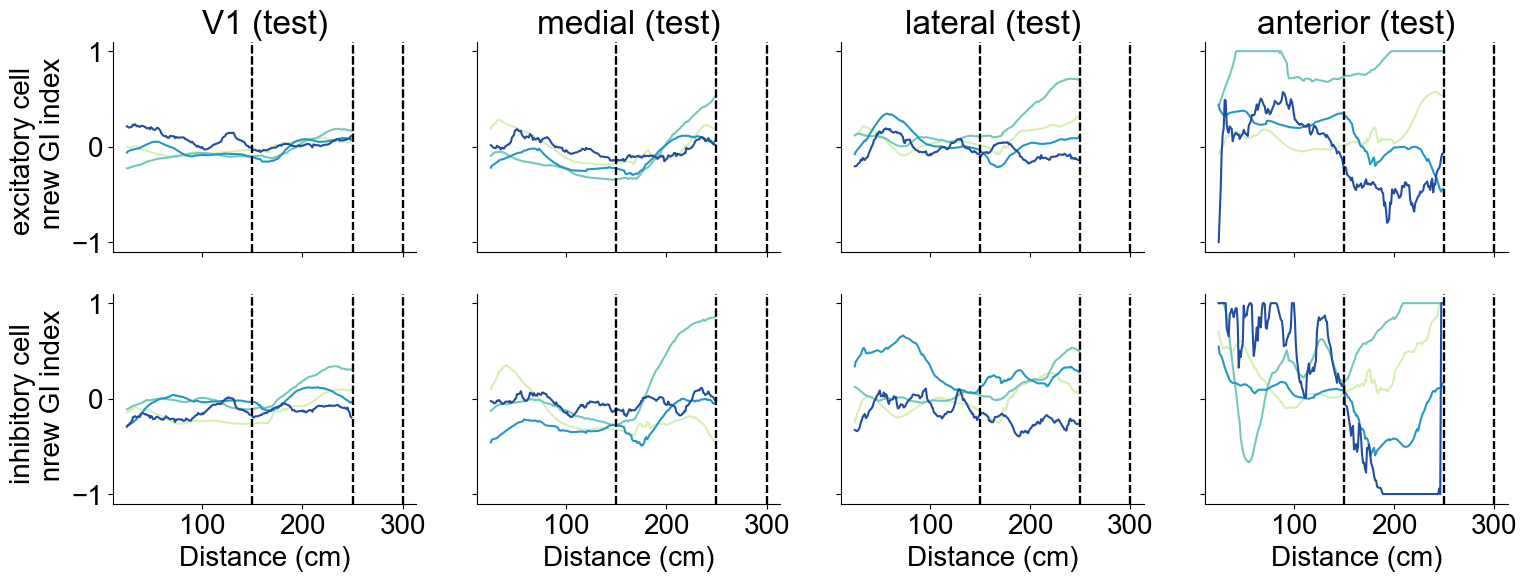

In [67]:
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
palette = sns.color_palette('YlGnBu', 4)  # 4 colors for 4 days
for day in range(4):
    for indexa, area in enumerate(areas):
        for redcell in range(2):
            gi_a = gis_n[day,redcell,indexa,:]
            gi_a = gi_a[25:250]
            ax[redcell,indexa].plot(np.arange(25,250), gi_a * -1, color = palette[day], linewidth = 1.5)
            ax[redcell,indexa].set_xlabel('Distance (cm)')
            ax[redcell,indexa].axvline(x=150, color='k', linestyle='--')
            ax[redcell,indexa].axvline(x=250, color='k', linestyle='--')
            ax[redcell,indexa].axvline(x=300, color='k', linestyle='--')
            if redcell == 0:
                ax[redcell,indexa].set_xlabel('')
                ax[redcell,indexa].set_title(f"{area} (test)")
            else:
                ax[redcell,indexa].set_xlabel('Distance (cm)')
        # if indexa != 0 do not plot the yticks
            if indexa == 0:
                if redcell == 0:
                    ax[redcell,indexa].set_ylabel('excitatory cell \n nrew GI index')
                else:
                    ax[redcell,indexa].set_ylabel('inhibitory cell \n nrew GI index')
sns.despine()

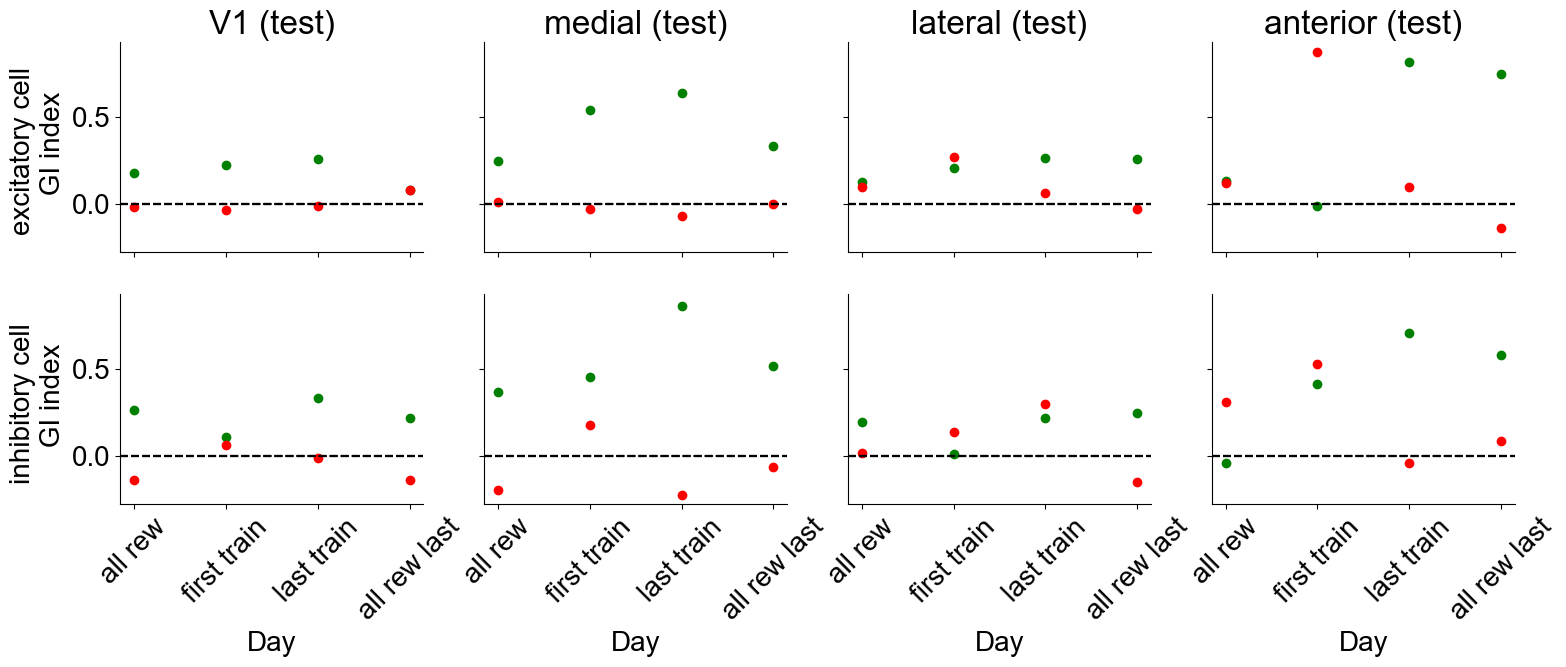

In [68]:
fig, ax = plt.subplots(2,4, figsize=(18,6), sharey=True, sharex=True)
palette = sns.color_palette('YlGnBu', 4)  # 4 colors for 4 days
for day in range(4):
    for indexa, area in enumerate(areas):
        for redcell in range(2):
            gi_r = gis[day,redcell,indexa,:]
            gi_nr = gis_n[day,redcell,indexa,:]
            gi_rp = gi_r[25:275].mean()
            gi_nrp = gi_nr[25:275].mean()
            ax[redcell,indexa].scatter(day, gi_rp, color = 'g')
            ax[redcell,indexa].scatter(day, gi_nrp*-1, color = 'r')
            ax[redcell,indexa].set_xlabel('Day')
            if redcell == 0:
                ax[redcell,indexa].set_xlabel('')
                ax[redcell,indexa].set_title(f"{area} (test)")
            else:
                ax[redcell,indexa].set_xticks([0,1,2,3], ['all rew', 'first train', 'last train', 'all rew last'], rotation=45)
        # if indexa != 0 do not plot the yticks
            if indexa == 0:
                if redcell == 0:
                    ax[redcell,indexa].set_ylabel('excitatory cell \n GI index')
                else:
                    ax[redcell,indexa].set_ylabel('inhibitory cell \n GI index')
            ax[redcell,indexa].axhline(y=0, color='k', linestyle='--')
                    
sns.despine()

In [69]:
gis_df = []

for day in range(4):
    for indexa, area in enumerate(areas):
        for redcell in range(2):
            gi_r = gis[day,redcell,indexa,:]
            gi_nr = gis_n[day,redcell,indexa,:]
            gi_rp = gi_r[25:275].mean()
            gi_nrp = gi_nr[25:275].mean()
            if redcell == 0:
                cell = 'excitatory'
            else:
                cell = 'inhibitory'
            gis_df.append({'mouse': 'VG11', 'sess': 1, 'area': area, 'day': day, 'gi rew': gi_rp, 'gi nrew': gi_nrp*-1, 'cell type': cell})
gis_df = pd.DataFrame(gis_df)
gis_df
# rename values of column day:
gis_df['day'] = gis_df['day'].replace({0:'allrew first', 1:'first training', 2:'optimal', 3:'allrew last'})

In [70]:
gis_df.to_csv(r"C:\Users\labadmin\Documents\category-neural\data\VG14\25_275\gi_index.csv")